In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
import kaggle

In [ ]:
!kaggle datasets download -d birdy654/cifake-real-and-ai-generated-synthetic-images

 89% 93.0M/105M [00:00<00:00, 128MB/s]
100% 105M/105M [00:00<00:00, 116MB/s] 


In [ ]:
import zipfile
zip_ref=zipfile.ZipFile('/content/cifake-real-and-ai-generated-synthetic-images.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
import cv2
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt


In [ ]:
train_dir = '/content/train'
test_dir = '/content/test'

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
for layer in base_model.layers:
    layer.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
batch_size=32

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

In [ ]:
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(32,32),
                                                    batch_size=batch_size, class_mode='binary')


Found 100000 images belonging to 2 classes.


In [ ]:
history = model.fit(train_generator, steps_per_epoch=train_generator.n // batch_size, epochs=50)

Epoch 1/50
3125/3125 [==============================] - 116s 37ms/step - loss: 0.4113 - accuracy: 0.8126
Epoch 2/50
3125/3125 [==============================] - 102s 33ms/step - loss: 0.3781 - accuracy: 0.8300
Epoch 3/50
3125/3125 [==============================] - 102s 33ms/step - loss: 0.3635 - accuracy: 0.8391
Epoch 4/50
3125/3125 [==============================] - 100s 32ms/step - loss: 0.3562 - accuracy: 0.8420
Epoch 5/50
3125/3125 [==============================] - 102s 32ms/step - loss: 0.3464 - accuracy: 0.8482
Epoch 6/50
3125/3125 [==============================] - 102s 33ms/step - loss: 0.3424 - accuracy: 0.8512
Epoch 7/50
3125/3125 [==============================] - 101s 32ms/step - loss: 0.3357 - accuracy: 0.8546
Epoch 8/50
3125/3125 [==============================] - 103s 33ms/step - loss: 0.3323 - accuracy: 0.8561
Epoch 9/50
3125/3125 [==============================] - 106s 34ms/step - loss: 0.3273 - accuracy: 0.8587
Epoch 10/50
3125/3125 [==============================] 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
model.save('/content/drive/MyDrive/ai_model')

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(32,32),
                                                  batch_size=batch_size, class_mode='binary', shuffle=False)

Found 20000 images belonging to 2 classes.


In [ ]:
predictions = model.predict(test_generator)
labels = [0 if pred < 0.5 else 1 for pred in predictions]

625/625 [==============================] - 10s 15ms/step


In [ ]:
accuracy = np.sum(np.array(test_generator.labels) == np.array(labels)) / len(labels)

In [ ]:
print("\nAccuracy:", accuracy)



Accuracy: 0.893


In [ ]:
cm = confusion_matrix(test_generator.labels, labels)
print("\nConfusion Matrix:")
print(cm)


class_names = test_generator.class_indices.keys()
classification_rep = classification_report(test_generator.labels, labels, target_names=class_names)
print("\nClassification Report:")
print(classification_rep)


mAP = average_precision_score(test_generator.labels, predictions)
print("\nMean Average Precision (mAP):", mAP)


Confusion Matrix:
[[9150  850]
 [1290 8710]]

Classification Report:
              precision    recall  f1-score   support

        FAKE       0.88      0.92      0.90     10000
        REAL       0.91      0.87      0.89     10000

    accuracy                           0.89     20000
   macro avg       0.89      0.89      0.89     20000
weighted avg       0.89      0.89      0.89     20000


Mean Average Precision (mAP): 0.9596197301956395


In [ ]:
import seaborn as sns

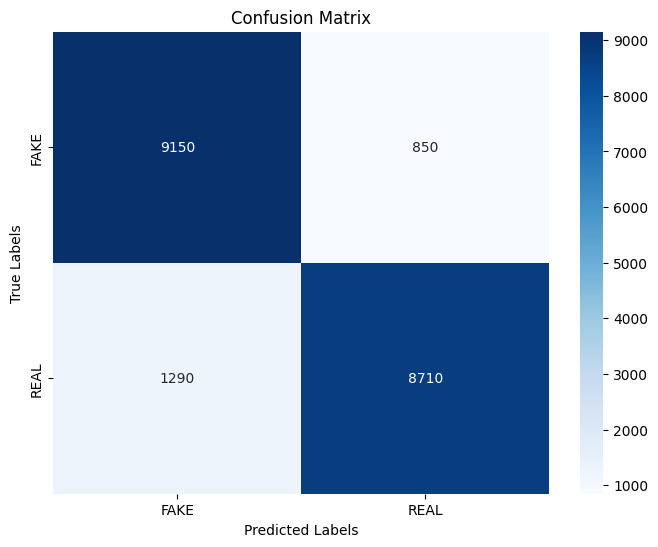

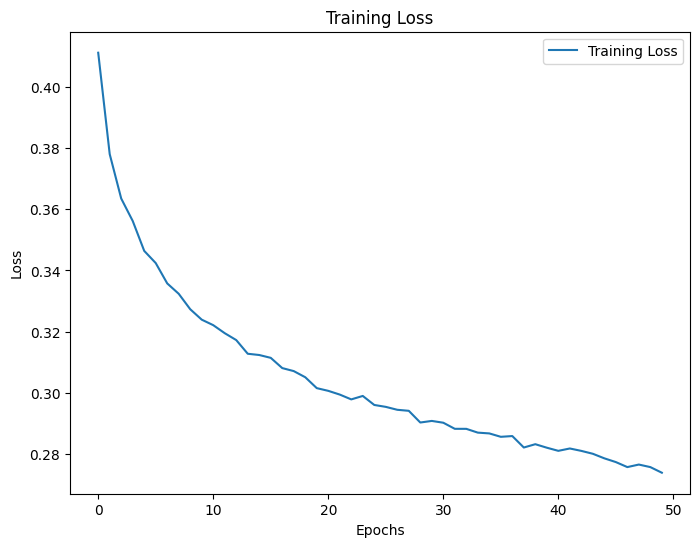

In [ ]:
cm = confusion_matrix(test_generator.labels, labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

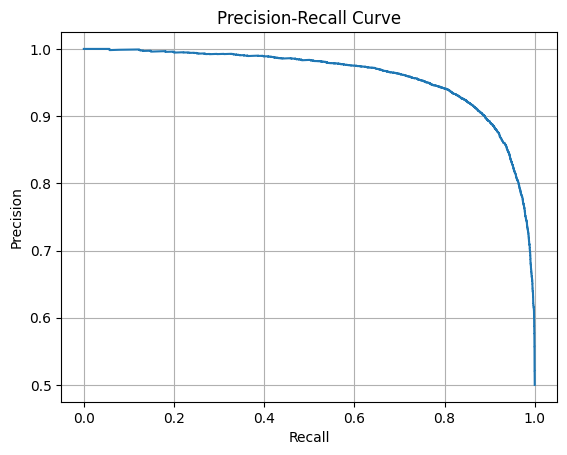

In [ ]:
from sklearn.metrics import precision_recall_curve


precision, recall, _ = precision_recall_curve(test_generator.labels, predictions)

plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

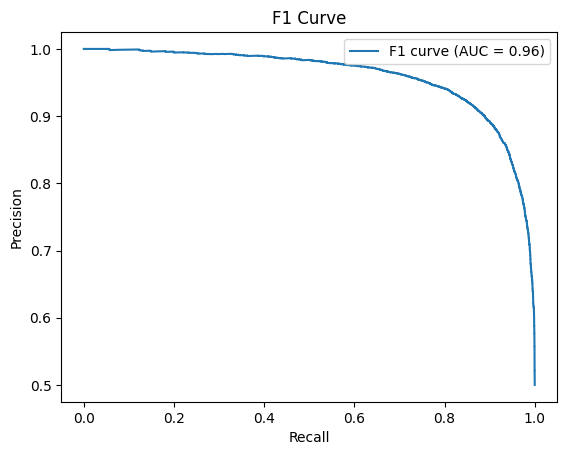

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc


precision, recall, thresholds = precision_recall_curve(test_generator.labels, predictions)


f1_scores = 2 * (precision * recall) / (precision + recall)


auc_score = auc(recall, precision)


plt.plot(recall, precision, label='F1 curve (AUC = {:.2f})'.format(auc_score))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('F1 Curve')
plt.legend()
plt.show()

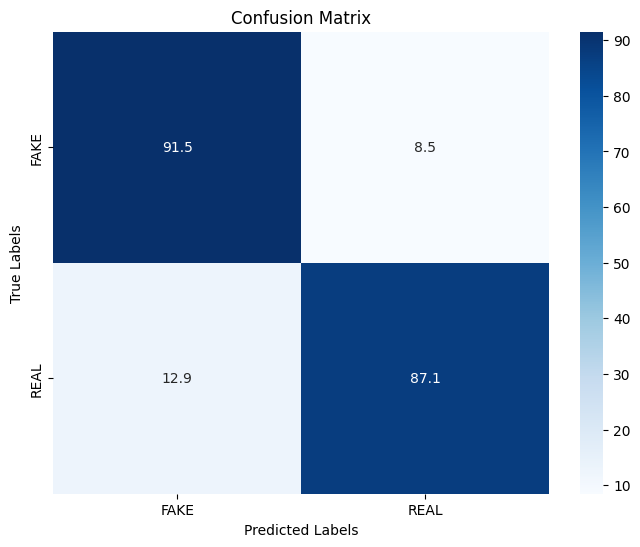

In [ ]:
cm = confusion_matrix(test_generator.labels, labels)
cm_percent = cm / cm.sum(axis=1).reshape(-1, 1) * 100

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent, annot=True, cmap='Blues', fmt='.1f', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

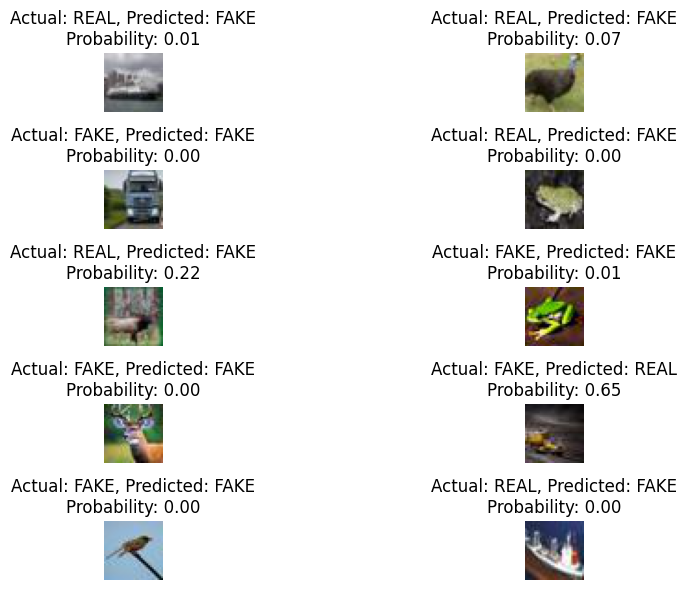

In [ ]:
sample_indices = np.random.choice(len(test_generator), size=10, replace=False)
sample_images = []
sample_actual_labels = []
sample_predicted_labels = []
sample_probabilities = []

for i in sample_indices:
    image, actual_labels = test_generator[i]
    predicted_label = labels[i]
    probability = predictions[i][0]
    sample_images.append(image[0])
    sample_actual_labels.append(actual_labels[0])
    sample_predicted_labels.append(predicted_label)
    sample_probabilities.append(probability)



num_images = len(sample_images)
num_rows = int(np.ceil(num_images / 2))
num_cols = min(num_images, 2)

plt.figure(figsize=(12, 6))
for i in range(len(sample_images)):
    plt.subplot(num_rows, num_cols, i+1)
    plt.imshow(sample_images[i])
    actual_label = "FAKE" if sample_actual_labels[i] == 0 else "REAL"
    predicted_label = "FAKE" if sample_predicted_labels[i] == 0 else "REAL"
    plt.title(f"Actual: {actual_label}, Predicted: {predicted_label}\nProbability: {sample_probabilities[i]:.2f}")
    plt.axis('off')
plt.tight_layout()
plt.show()